1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

C:\Users\GruXsqK\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\GruXsqK\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy=0.3).fit_sample(X_train, y_train)

In [4]:
X_train_df = pd.DataFrame(X_train_balanced, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

### Взаимная информация

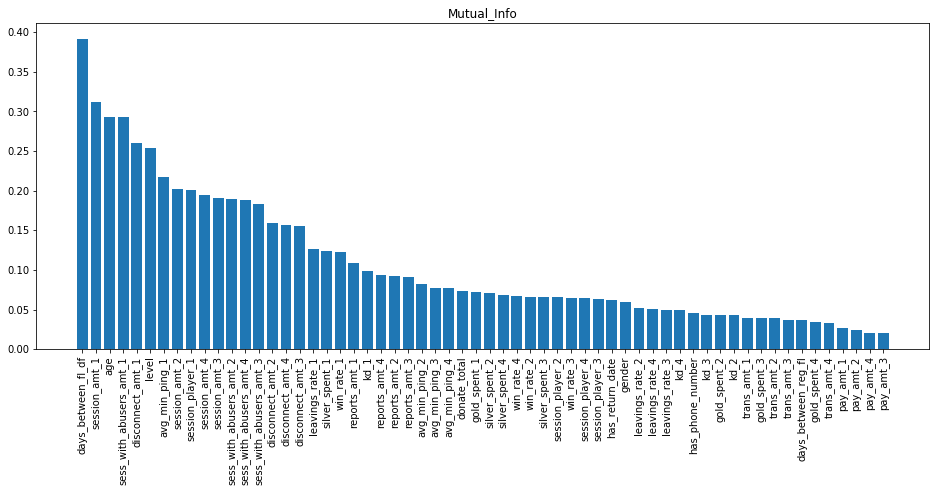

In [5]:
mi = mutual_info_classif(X_train_balanced, y_train_balanced)
feature_importance_mi = plot_importance(mi, X.columns, 'Mutual_Info')

In [6]:
X_train_mi = X_train_df[feature_importance_mi[0][:25]]
X_test_mi = X_test_df[feature_importance_mi[0][:25]]

In [7]:
fitted_clf_mi = xgb_fit_predict(X_train_mi, y_train_balanced, X_test_mi, y_test)

Precision: 0.2901453385324353
Recall: 0.3946480231436837
F1: 0.33442288049029617
Log Loss: 0.13371710223302416
ROC AUC: 0.8955953603781064


### RFE (Recursive Feature Elimination)

Optimal number of features : 50


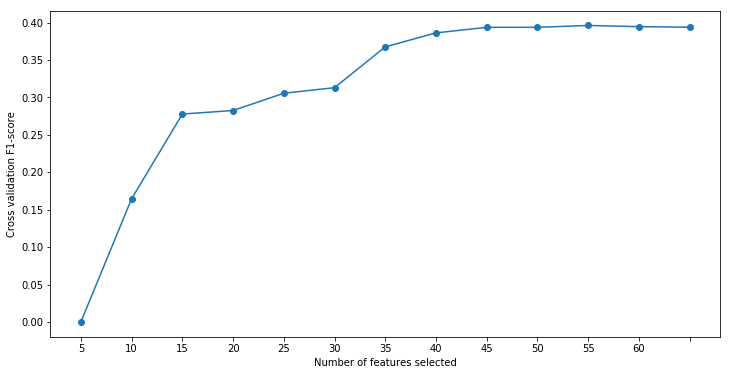

In [8]:
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features_rfe = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [9]:
X_train_rfe = X_train_df[good_features_rfe]
X_test_rfe = X_test_df[good_features_rfe]

In [10]:
fitted_clf_rfe = xgb_fit_predict(X_train_rfe, y_train_balanced, X_test_rfe, y_test)

Precision: 0.29142185663924797
Recall: 0.4185149469623915
F1: 0.34359228104898565
Log Loss: 0.1338555302918321
ROC AUC: 0.8984139686495598


### Permutation Importance (PI)

In [11]:
from ELI5 import PermutationImportance

In [12]:
fitted_clf = xgb_fit_predict(X_train_df, y_train_balanced, X_test_df, y_test)

Precision: 0.2930574098798398
Recall: 0.42333654773384766
F1: 0.3463510848126233
Log Loss: 0.13322467940530783
ROC AUC: 0.8983387849044021


In [13]:
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_test_df, y_test)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

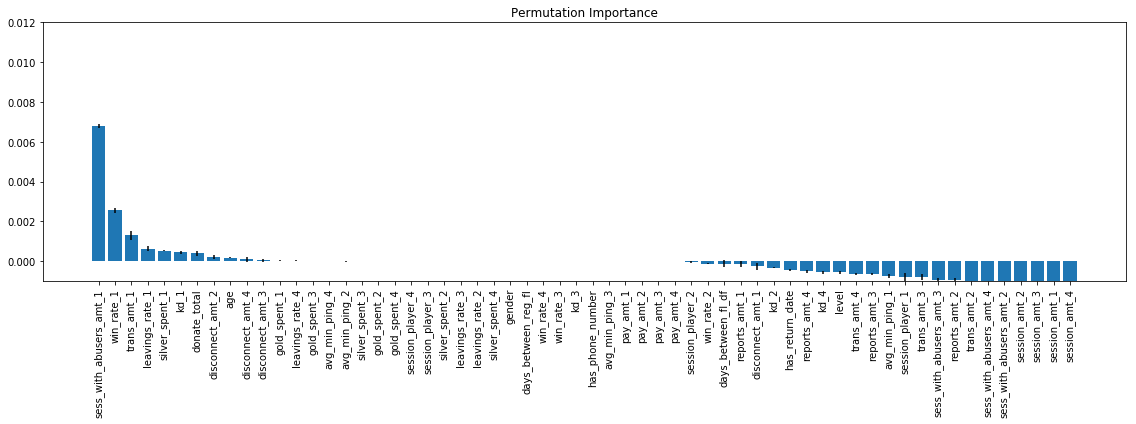

In [14]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

In [15]:
good_features_pi = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features_pi.shape[0])

Кол-во отобранных признаков: 17


In [16]:
X_train_pi = X_train_df[good_features_pi]
X_test_pi = X_test_df[good_features_pi]

In [17]:
fitted_clf_pi = xgb_fit_predict(X_train_pi, y_train_balanced, X_test_pi, y_test)

Precision: 0.24825318536785862
Recall: 0.29122468659594986
F1: 0.26802751275793213
Log Loss: 0.17269891253120695
ROC AUC: 0.8013603751787046


Метод отбора признаков с помощью взаимной информации обладает лучшим показателем F1 и в тоже время незначительно отличается от показателя F1 без отбора признаков, что говорит о том, что выбирая признаки методом взаимной информации мы не теряем в качестве модели.

2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

In [18]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.metrics import classification_report

In [19]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [20]:
model_lr = LogisticRegression()
model_lr.fit(X_train_balanced, y_train_balanced)

y_train_pred = model_lr.predict(X_train_balanced)
y_test_pred = model_lr.predict(X_test_df)

get_classification_report(y_train_balanced, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.97      0.89    318955
           1       0.72      0.30      0.42     95686

    accuracy                           0.81    414641
   macro avg       0.77      0.63      0.66    414641
weighted avg       0.80      0.81      0.78    414641

TEST

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    136695
           1       0.20      0.29      0.24      4148

    accuracy                           0.95    140843
   macro avg       0.59      0.63      0.61    140843
weighted avg       0.96      0.95      0.95    140843

CONFUSION MATRIX

col_0            0     1
is_churned              
0           131906  4789
1             2925  1223


In [21]:
model_knn = KNC(n_jobs=-1)
model_knn.fit(X_train_balanced, y_train_balanced)

y_train_pred = model_knn.predict(X_train_balanced)
y_test_pred = model_knn.predict(X_test_df)

get_classification_report(y_train_balanced, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    318955
           1       0.83      1.00      0.91     95686

    accuracy                           0.95    414641
   macro avg       0.91      0.97      0.94    414641
weighted avg       0.96      0.95      0.95    414641

TEST

              precision    recall  f1-score   support

           0       0.98      0.91      0.95    136695
           1       0.13      0.42      0.20      4148

    accuracy                           0.90    140843
   macro avg       0.55      0.67      0.57    140843
weighted avg       0.96      0.90      0.92    140843

CONFUSION MATRIX

col_0            0      1
is_churned               
0           124756  11939
1             2392   1756


XGBClassifier имеет более высокий показатель F1 по целевой переменной, чем LogisticRegression и KNeighborsClassifier с настройками по-умолчанию. Показатель моделей можно повысить более тонкой настройкой.

3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [22]:
import seaborn as sns

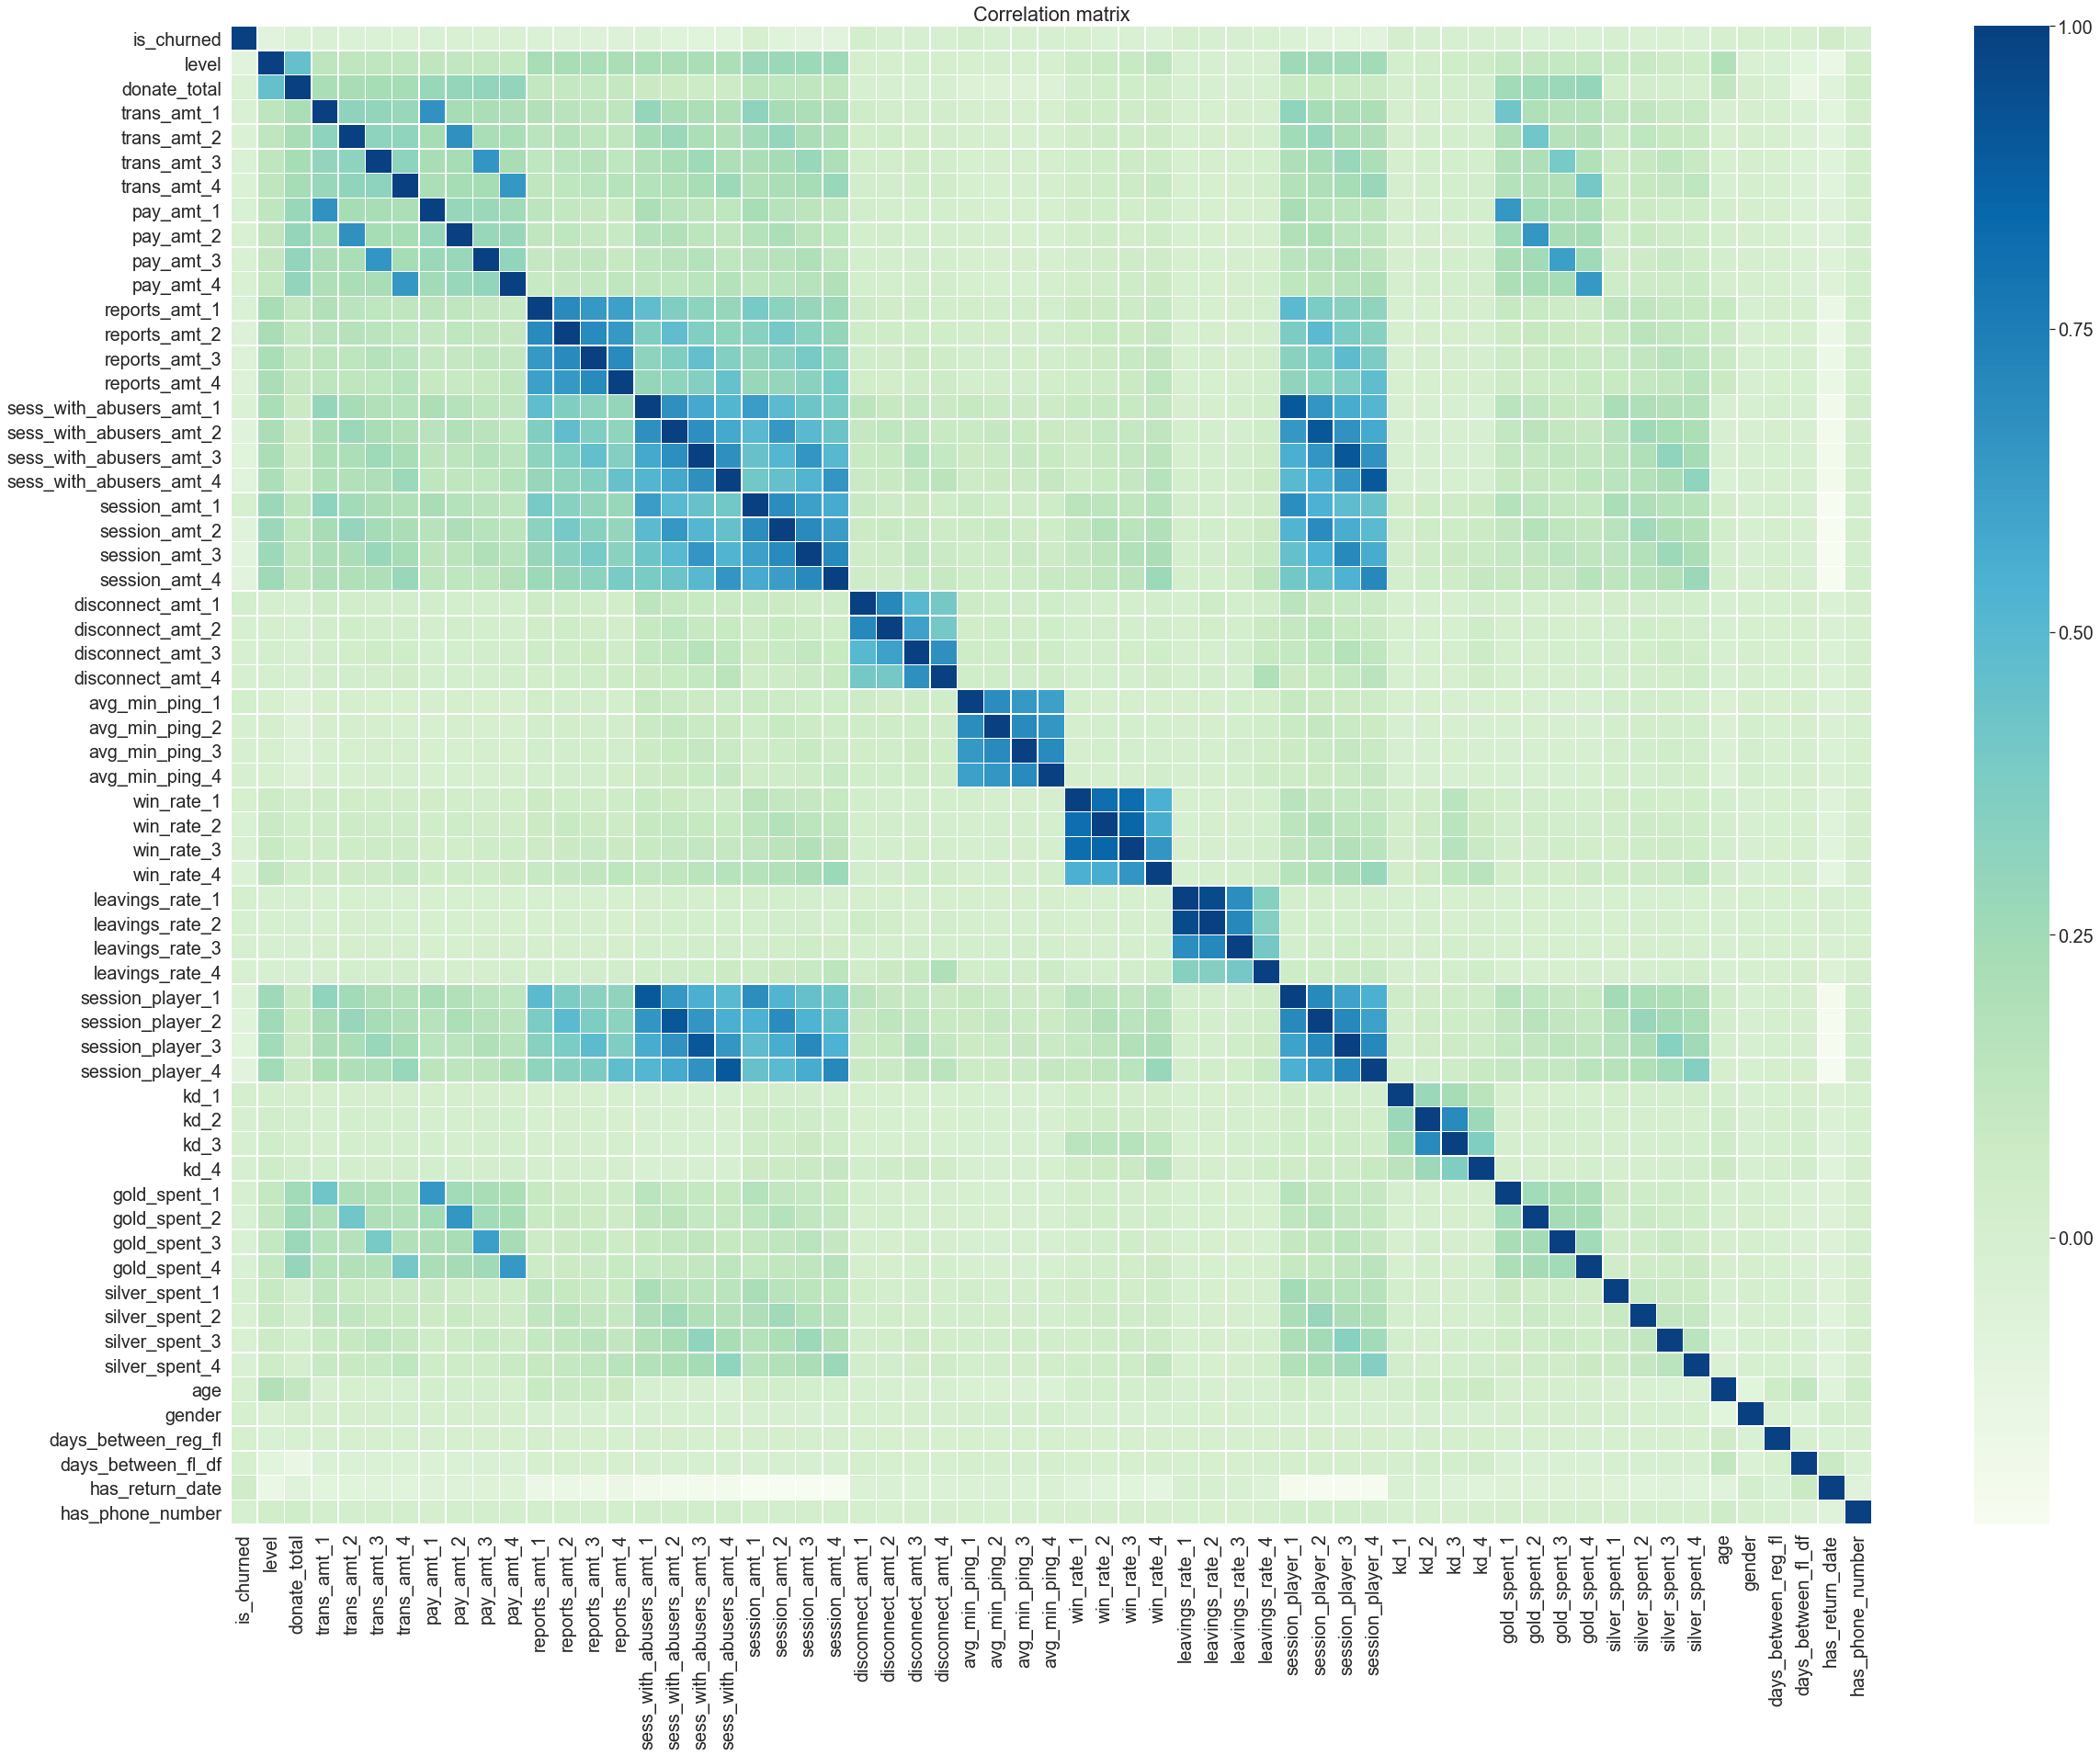

In [23]:
plt.figure(figsize = (40,30))

sns.set(font_scale=1.8)
sns.heatmap(dataset.drop(['user_id'], axis=1).corr(), annot=False, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Из матрицы корреляций видно, что только некоторые признаки коррелируют между собой, а основная кореляция наблюдается внутри одного признака, который наблюдается на каждой неделе. Так 'avg_min_ping' за все недели можно объеденить в одно вычислением среднего или PCA, 'leaving_rate_1' и 'leaving_rate_2' объединить по тому же принципу. 'win_rate' сгруппировать по 2 недели.

4. __(*)__ Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 

Information value (IV) предназначен, в основном, для бинарной модели логистической регрессии. Случайный лес хорошо находит нелинейные зависимости и выбор переменных через IV может не дать хорошую модель.